In [1]:
!pwd

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.executable

/c/Users/shingo/jupyter_notebook/stock_work/03.stock_repo/time_series_analysis


'C:\\Users\\shingo\\Anaconda3\\envs\\stock\\python.exe'

### モジュールimport

In [2]:
#import sys
#sys.path.append('sarimax_analysis')
import sarimax_analysis as s_ana

# ARモデル作成
### 参考:pythonでARモデルの推定 
- https://analytics-note.xyz/time-series/statsmodels-ar/

(500,)
[62.79680908 62.05010742 62.7525264  63.26149169 63.92240948 64.04374944
 64.94206705 65.61346048 65.72826376 66.02346591]


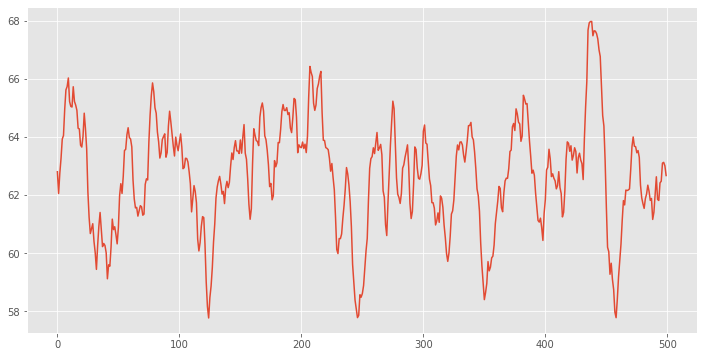

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

phi_1 = 1.4
phi_2 = -0.48
c = 5
sigma = 0.5
T = 500
# 過程の期待値
mu = c/(1-phi_1-phi_2)

# データの生成
ar_data = np.zeros(T)
ar_data[0] = mu + np.random.normal(0, sigma)
ar_data[1] = mu + np.random.normal(0, sigma)
for t in range(2, T):
    ar_data[t] = c + phi_1*ar_data[t-1] + phi_2*ar_data[t-2] + np.random.normal(0, sigma)

print(ar_data.shape)
print(ar_data[:10])
    
# データの可視化 (記事中では出力は略します)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ar_data)
plt.show()

In [4]:
# train/test set分割
ratio = 0.95
train = ar_data[: int(len(ar_data) * ratio)]
test = ar_data[int(len(ar_data) * ratio):]
print(train.shape, train[:5])
print(test.shape, test[:5])

(475,) [62.79680908 62.05010742 62.7525264  63.26149169 63.92240948]
(25,) [63.44951484 63.52600437 63.29156492 62.33779856 61.9010516 ]


In [5]:
model = s_ana.make_ar_model(train)

推定したARモデルの次数: 2
定数項c, 自己回帰係数Φ1,Φ2,… : [ 3.95192322  1.42083888 -0.48381416]
ホワイトノイズの分散: 0.23913388379499423


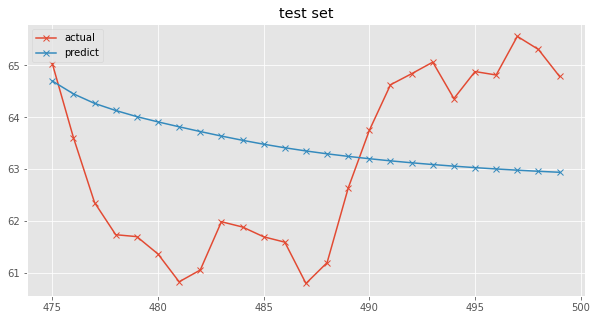

In [6]:
# startはモデルの次数より大きくないとエラーになる
pred_ar_data = model.predict(start=train.shape[0], end=ar_data.shape[0] - 1)

def _plot_test(predict, test, test_index):
    plt.figure(figsize=(10, 5))
    plt.plot(test_index, test, marker='x', label='actual')
    plt.plot(test_index, predict, marker='x', label='predict')
    plt.title('test set')
    plt.legend()
    plt.show()
    
_plot_test(pred_ar_data, test,  np.array(range(train.shape[0],ar_data.shape[0])))

# 平均気温の時系列データをAR/ARMA/ARIMAモデルで予測する
- https://takaxtech.com/2019/02/10/article291/

In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa import stattools as st


def _get_train_test(ts, ratio=0.998):
    """ train/test set分割 """
    # Seriesとして扱うとpredict難しくなるからnumpyにする
    train = ts[: int(len(ts) * ratio)].values
    test = ts[int(len(ts) * ratio):].values
    # 時刻は別の変数で保持
    # 今回の1日ごとのデータで日付をインデックスにすると、うまくモデルに適用できないので
    str_index = ts.index
    train_index = str_index[:int(len(ts) * ratio)].values
    test_index = str_index[int(len(ts) * ratio):].values

    return train, test, train_index, test_index


def _plot_test(predict, test, test_index):
    plt.figure(figsize=(10, 5))
    plt.plot(test_index, test, marker='x', label='actual')
    plt.plot(test_index, predict, marker='x', label='predict')
    plt.title('test set')
    plt.legend()
    plt.show()

### 東京の平均気温データでやる場合

,MT,均質番号
2001-01-01,7.5,1.0
2001-01-02,8.3,1.0
2001-01-03,7.8,1.0
2001-01-04,4.7,1.0
2001-01-05,5.7,1.0


(6560,) [7.5 8.3 7.8 4.7 5.7]
(14,) [8.9 8.2 8.7 8.9 9. ]
(6560,) ['2001-01-01T00:00:00.000000000' '2001-01-02T00:00:00.000000000'
 '2001-01-03T00:00:00.000000000' '2001-01-04T00:00:00.000000000'
 '2001-01-05T00:00:00.000000000']
(14,) ['2018-12-18T00:00:00.000000000' '2018-12-19T00:00:00.000000000'
 '2018-12-20T00:00:00.000000000' '2018-12-21T00:00:00.000000000'
 '2018-12-22T00:00:00.000000000']


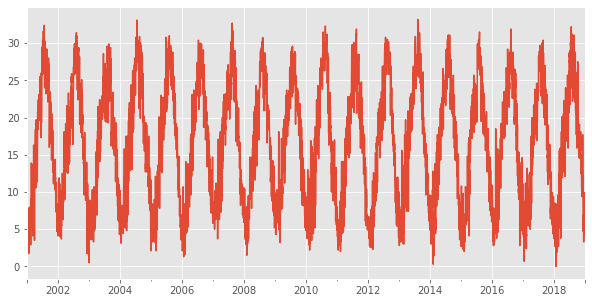

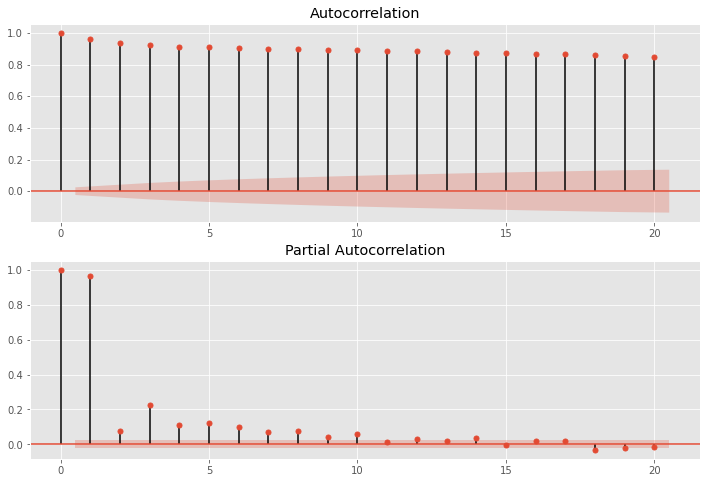

In [8]:
# https://www.data.jma.go.jp/gmd/risk/obsdl/index.php から2001-2018年の東京の平均気温ダウンロードした
dateparse = lambda d: pd.datetime.strptime(d, '%Y/%m/%d')
df = pd.read_csv('kion18y.csv',
                skiprows=5,
                index_col=0,
                parse_dates=[0],
                date_parser=dateparse,
                dtype='float',
                encoding='shift-jis')
df = df.rename(columns={'Unnamed: 1': 'MT'})
display(df.head())
ts = df['MT']
train, test, train_index, test_index = _get_train_test(ts)

print(train.shape, train[:5])
print(test.shape, test[:5])
print(train_index.shape, train_index[:5])
print(test_index.shape, test_index[:5])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ts.plot(ax=ax)
plt.show()

# train setについて自己相関（Autocorrelation）プロット
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=20, ax=ax1)

# 偏自己相関（Partial Autocorrelation）プロット
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train,lags=20, ax=ax2)

### 飛行機の乗客数データでやる場合

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


(115,) [112. 118. 132. 129. 121.]
(29,) [505. 404. 359. 310. 337.]
(115,) ['1949-01-01T00:00:00.000000000' '1949-02-01T00:00:00.000000000'
 '1949-03-01T00:00:00.000000000' '1949-04-01T00:00:00.000000000'
 '1949-05-01T00:00:00.000000000']
(29,) ['1958-08-01T00:00:00.000000000' '1958-09-01T00:00:00.000000000'
 '1958-10-01T00:00:00.000000000' '1958-11-01T00:00:00.000000000'
 '1958-12-01T00:00:00.000000000']


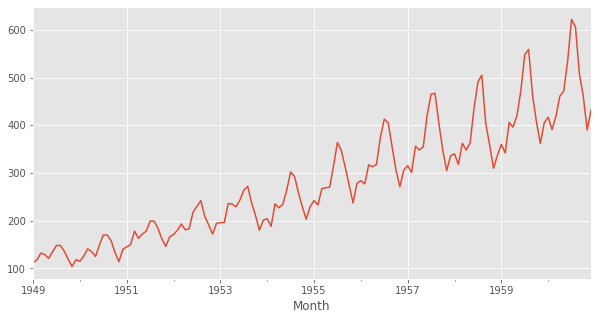

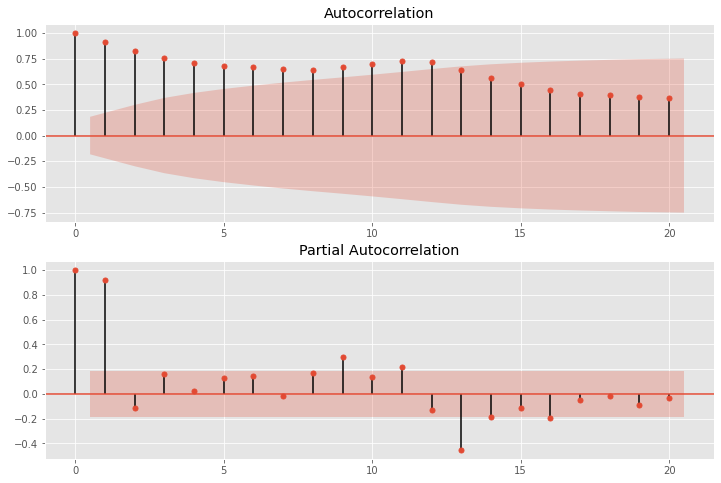

In [9]:
# csvは https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv からダウンロードした
df = pd.read_csv('AirPassengers.csv',
                 index_col=0, parse_dates=[0], dtype='float')
display(df.head())
# pandasのSeriesに乗客数データを格納
ts = df['#Passengers']
train, test, train_index, test_index = _get_train_test(ts, ratio=0.8)

print(train.shape, train[:5])
print(test.shape, test[:5])
print(train_index.shape, train_index[:5])
print(test_index.shape, test_index[:5])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ts.plot(ax=ax)
plt.show()

# train setについて自己相関（Autocorrelation）プロット
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=20, ax=ax1)

# 偏自己相関（Partial Autocorrelation）プロット
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train,lags=20, ax=ax2)

### AR

推定したARモデルの次数: 5
定数項c, 自己回帰係数Φ1,Φ2,… : [ 6.61249535  1.31503758 -0.59320695  0.32874105 -0.37518689  0.31211291]
ホワイトノイズの分散: 586.1986270729076


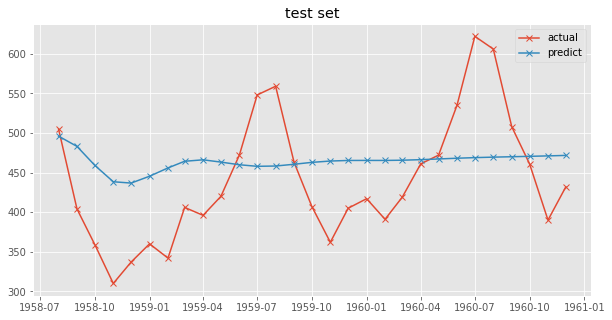

In [10]:
model_fit = s_ana.make_ar_model(train)
ar_predict = model_fit.predict(start=train.shape[0], end=ts.shape[0]-1)
_plot_test(ar_predict, test, test_index)

### ARMA

C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



推定したARMAモデルの次数: (4, 2)


C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



定数項c, 自己回帰係数Φ1,Φ2,… . 移動平均係数θ1,θ2,…: [ 2.72240909e+03  2.79940512e+00 -2.92068803e+00  1.20953044e+00
 -8.82525411e-02 -1.83005952e+00  9.39661467e-01]
ホワイトノイズの分散: 473.0300695338812
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  115
Model:                     ARMA(4, 2)   Log Likelihood                -524.399
Method:                       css-mle   S.D. of innovations             21.749
Date:                Sun, 31 May 2020   AIC                           1064.798
Time:                        13:17:14   BIC                           1086.757
Sample:                             0   HQIC                          1073.711
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2722.4091       

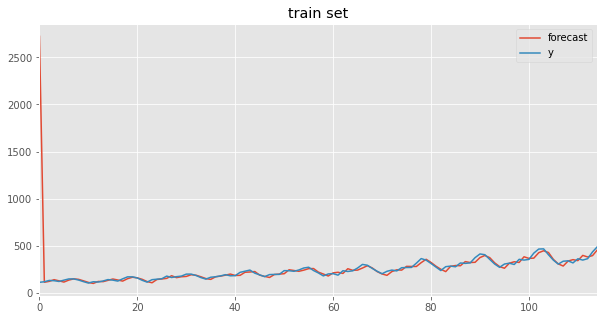

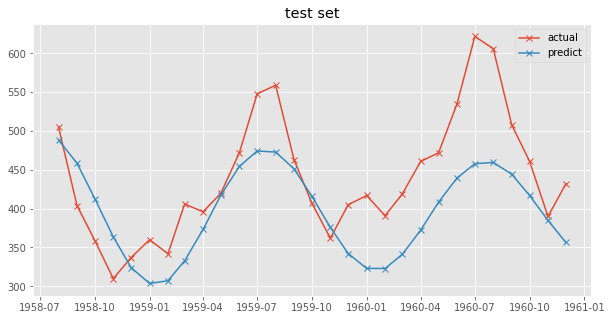

In [11]:
model_fit = s_ana.make_arma_model(train)
print(model_fit.summary())
arma_predict = model_fit.predict(start=train.shape[0], end=ts.shape[0] - 1)
_plot_test(arma_predict, test, test_index)

### ARIMA

C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



推定したARMAモデルの次数: (4, 2)
定数項c, 自己回帰係数Φ1,Φ2,… . 移動平均係数θ1,θ2,…: [ 2.56320047  0.24680184  0.38592887 -0.22744668 -0.20475346 -0.07907261
 -0.92092733]
ホワイトノイズの分散: 440.7986250291572
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -511.441
Method:                       css-mle   S.D. of innovations             20.995
Date:                Sun, 31 May 2020   AIC                           1038.881
Time:                        13:17:18   BIC                           1060.771
Sample:                             1   HQIC                          1047.765
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5632      0.143 

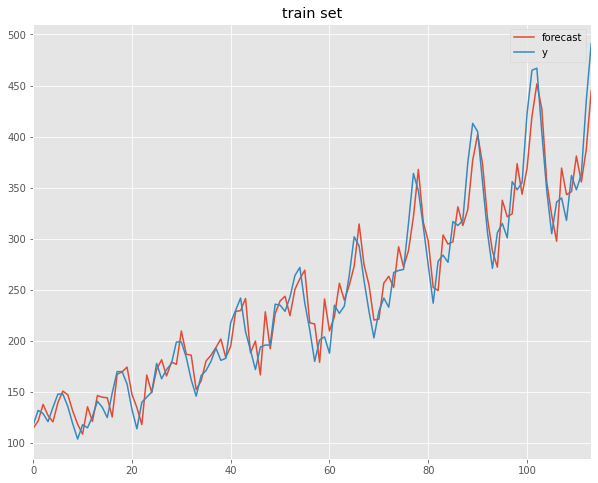

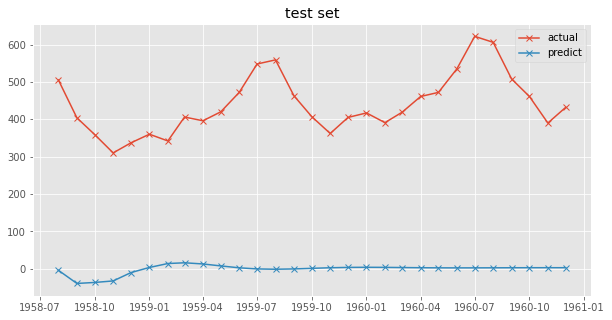

In [12]:
model_fit = s_ana.make_arima_model(train, param_d=1)
print(model_fit.summary())
arima_predict = model_fit.predict(start=train.shape[0], end=ts.shape[0] - 1)
_plot_test(arima_predict, test, test_index)

### SARIMA

C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



推定したARMAモデルの次数: (4, 2)


C:\Users\shingo\Anaconda3\envs\stock\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



定数項c, 自己回帰係数Φ1,Φ2,… . 移動平均係数θ1,θ2,…: [ 1.08553535e+00  5.61615860e-01 -7.20692069e-01  7.43581827e-02
 -3.04099670e-01 -6.92250256e-01 -5.26372327e-01  4.93865597e-01
  8.09520304e+01]
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  115
Model:             SARIMAX(4, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -317.355
Date:                              Sun, 31 May 2020   AIC                            652.710
Time:                                      13:17:26   BIC                            674.903
Sample:                                           0   HQIC                           661.646
                                              - 115                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025     

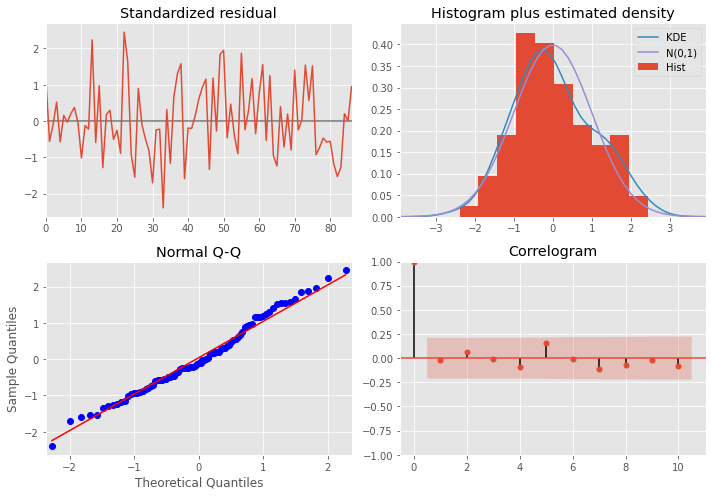

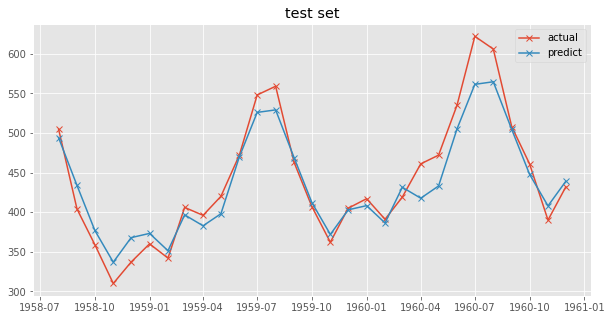

In [13]:
model_fit = s_ana.make_sarimax_model(train, param_d=0, param_P=1, param_D=1, param_Q=1, param_s=12)
print(model_fit.summary())
arima_predict = model_fit.predict(start=train.shape[0], end=ts.shape[0] - 1)
_plot_test(arima_predict, test, test_index)